load lists from files
Creating train generator with 1018 samples.
max flow: 6.9131 flow range: u = -4.692 .. 1.808; v = -4.176 .. 6.756



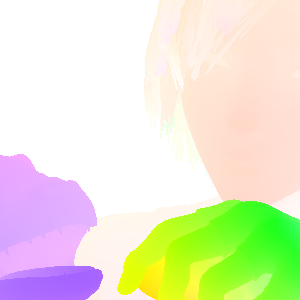

In [8]:
import numpy as np
import sys
sys.path.append('/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN')
import tflib as lib
from tflib.save_images import save_images
import tflib.SINTELdataDesktopFlow as sintel
import tflib.flow_handler as fh
#import cv2
from IPython.core.display import Image, display
import PIL
%matplotlib inline
import matplotlib.pyplot as plt

def show(image): # to show np array as image
    a = (image).astype(np.uint8)
    display(PIL.Image.fromarray(a))

BATCH_SIZE = 10 # Batch size
TARGET_SIZE = 300
OUT_DIM_FLOW = TARGET_SIZE*TARGET_SIZE*2

gen = sintel.load_train_gen(BATCH_SIZE,(TARGET_SIZE, TARGET_SIZE, 3))
_data, _flow = next(gen)
# images: (n, 6144) -- 3072 + 3072 = two images for 32
# flows: (n, 4096) -- 2048 + 2048 = two flows for 32
            
outpath = "/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN/data/gentest/"

flows = _flow[0] # first from batch
flow1 = flows[0:OUT_DIM_FLOW] # (2048,) for 32
flow2 = flows[OUT_DIM_FLOW:] # (2048,) for 32
flow1 = flow1.reshape(TARGET_SIZE,TARGET_SIZE,2)
flow2 = flow2.reshape(TARGET_SIZE,TARGET_SIZE,2)

# save flow               # write_flo_file(flow, filename)  
# filename must be string and end in .flo. Flow must be in (w,h,2) format
# fh.write_flo_file(flow1, outpath+'sample_sintel_flow.flo')  
# load flow from file     # read_flo_file(filename)
# flowfile = fh.read_flo_file(outpath+"sample_sintel_flow.flo")

# show flow               # computeImg(flow)
flowimg = fh.computeImg(flow1)    # (200, 200, 3) # now color img!! :)

# write flow as png
# cv2.imwrite(outpath+'sample_sintel_flow2.png', flowimg) # for this delete inversion in flow handler
# visualize
#cv2.imshow(outpath+'sample_sintel_flow2.flo',flowimg)  # for this delete inversion in flow handler
#cv2.waitKey() # needed, whatever it does

show(flowimg) 

flowimage_T = np.transpose(flowimg, [2,0,1])  #  (3, 200, 200)
save_images(flowimage_T.reshape((1,3,TARGET_SIZE,TARGET_SIZE)), outpath+"flowsintel1.jpg")


In [6]:
from glob import glob
from os.path import join, isfile


def get_category_from_path(path):
    parts = path.split('/')
    return parts[-2]

root = '/home/linkermann/Desktop/MA/data/SINTEL/training/'
flow_root = join(root, 'flow')
image_root = join(root, 'clean')
validation_image_root = join(root, 'final')
flow_paths = join(root, 'flow/*/*.flo')
file_list = glob(flow_paths)
sorted_file_list= sorted(file_list)

lenli = len(sorted_file_list)
for i, file in enumerate(sorted_file_list):
    nextelem = sorted_file_list[(i+1)%lenli]
    # if(not(get_category_from_path(file) == get_category_from_path(nextelem))):
        # print("Next category @ "+ str(i) + "\n")